# Get translated protein product of isoforms

And calculate disordered protein scores of the proteins.

In [30]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import gffutils
import pybedtools
import re
import numpy as np
import seaborn as sns
sns.set(style='ticks', context='talk')
%matplotlib inline

v19db_filename = '/projects/ps-yeolab/genomes/hg19/gencode/v19/gencode.v19.annotation.gtf.db'
v19db = gffutils.FeatureDB(v19db_filename)

folder = '/projects/ps-yeolab/obotvinnik/singlecell_pnms'

prefix = 'skipped_exon_isoform_translations'
translated_fasta = '{}/{}.fa'.format(folder, prefix)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
figure_folder = '/home/obotvinnik/Dropbox/figures2/singlecell_pnms/isoform_protein_properties'
! mkdir $figure_folder

mkdir: cannot create directory `/home/obotvinnik/Dropbox/figures2/singlecell_pnms/isoform_protein_properties': File exists


## Translate isoform

## Read disordered scores from [0.2.09]

In [6]:
disordered_scores_df = pd.read_csv('/projects/ps-yeolab/obotvinnik/miso_helpers/hg19/isoform_disordered_scores.csv', index_col=0)
disordered_scores_df.head()

,isoform1,isoform2
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,{'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQN...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,{'HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEY...,{'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQN...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,{'HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEY...,{'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQN...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,{'LRPPDLAQRVQLWEHFQSLLWTYSRLREQEQCFAVEALERLIHP...
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,{'LPALEDQLSTLLAPVIISSMTMLEKLSDTYTCFSTENGNFLYVL...


When reading the saved dataframe from a file, the dicts were saved as strings to need to use Python's `eval` to "evaluate" the string into a Python object, like executing that string of code.

In [7]:
# ind = disordered_scores_df.notnull()
disordered_scores_df = disordered_scores_df.applymap(lambda x: eval(x) if not isinstance(x, float) else x)

In [8]:
disordered_scores_df.head().values

array([[nan,
        {'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS': 0.6618821782178218, 'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS': 0.638961797752809}],
       [ {'HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS': 0.604310294117647},
        {'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS': 0.6618821782178218, 'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS': 0.638961797752809}],
       [ {'HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFTPAPSPGDQSS': 0.5524732142857143},
        {'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSSGEDRRKAGGNNS': 0.6618821782178218, 'HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIPVQQAWSPHSTGPTGGSSAETETDSFSLPEEYFTPAPSPGDQSS': 0.638961797752809}],
       [nan,
        {'LRPPDLAQRVQLWEHFQSLLWTYSRLR

Get the disordered score from the shortest isoform

In [9]:
disordered_scores_df_values = disordered_scores_df.applymap(
    lambda x: min(x.items(), key=lambda k: len(k[0]))[-1] if not isinstance(x, float) else x)
disordered_scores_df_values.head()

,isoform1,isoform2
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,0.638962
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,0.604310,0.638962
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,0.552473,0.638962
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,0.153085
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,0.099842


In [10]:
disordered_scores_df_values.columns = disordered_scores_df_values.columns.map(lambda x: x + '_iupred_score')

### While we're here, also get the shortest protein product from the isoforms

In [11]:
isoform_translations = disordered_scores_df.applymap(
    lambda x: min(x.keys(), key=len) if not isinstance(x, float) else x)
isoform_translations.head()

,isoform1,isoform2
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFT...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,HSASSLRPADLLALILLVQDLYPSESTAEDDIQETDSFSLPEEYFT...,HSASSLRPADLLALILLVQDLYPSESTAEDDIQPSPRRARSSQNIP...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,LRPPDLAQRVQLWEHFQSLLWTYSRLREQEQCFAVEALERLIHPQL...
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,LPALEDQLSTLLAPVIISSMTMLEKLSDTYTCFSTENGNFLYVLHL...


In [12]:
isoform_translations.columns = isoform_translations.columns.map(lambda x: x + '_translation')

## Isoelectric point

In [13]:
from Bio import SeqUtils

In [14]:
from Bio.SeqUtils import ProtParam

Don't use protein sequences with stop codons

In [15]:
stop_codon = isoform_translations[isoform_translations.applymap(
        lambda x: '*' in x if isinstance(x, str) else False)].dropna(how='all')
print stop_codon.shape
stop_codon.head()

(4849, 2)


,isoform1_translation,isoform2_translation
exon:chr10:101507014-101507147:+@exon:chr10:101514286-101514391:+@exon:chr10:101515382-101515465:+,NaN,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQEV...
exon:chr10:101507014-101507147:+@exon:chr10:101514286-101514391:+@exon:chr10:101515382-101515891:+,NaN,FDMVHDPMAALETLLTLGFERVLTSGCDSSALEGLPLIKRLIEQEV...
exon:chr10:101977752-101977887:-@exon:chr10:101969352-101969546:-@exon:chr10:101964833-101964956:-,NaN,LVVEPMENWLQLMLNWDPQQRGGPVDLTLKQPRCFVLMDHILNLKI...
exon:chr10:102020723-102020785:-@exon:chr10:102019975-102020076:-@exon:chr10:102013178-102013296:-,NaN,LLLCVGNFFGSTQDAEWEEYKTGIKKAPIQTYVLGANNQETVKYFQ...
exon:chr10:102021736-102021820:-@exon:chr10:102020723-102020785:-@exon:chr10:102016019-102016233:-,LACGDVEGKFDILFNRVQAIQKKSGNFDVVKVSSLEARGCRLCTSV...,NaN


In [16]:
stop_codon.dropna()

,isoform1_translation,isoform2_translation
exon:chr10:120938267-120938345:-@exon:chr10:120936533-120936665:-@exon:chr10:120933249-120933384:-,MAAAVGRLLRASHLCVSYRNCCF**QS*RISRREL*SCRSLSGFPL...,MAAAVGRLLRASVARHVSAIPWGISATAALRPAACGRTSLTNLLCS...
exon:chr10:14920888-14920918:+@exon:chr10:14938845-14938976:+@exon:chr10:14941538-14941684:+,MAAVGAEARGGNHK*RS*KTRTVL*QQGNHVSL*SGL*V**IHSGC...,MAAVGAEARGGYGILSCKMERMARFYKYLGTFAKSEVPVTASAIL*...
exon:chr10:73892815-73892939:-@exon:chr10:73862608-73862725:-@exon:chr10:73856278-73857208:-,LQELVDRVLERFQASGLIVKEWNSVKLHATVMNTLFRKDPNVV*EL...,LQELVDRVLERFQASGLIVKEWNSVKLHATVMNTLFRKDPNELCLV...
exon:chr10:73892815-73892939:-@exon:chr10:73862608-73862725:-@exon:chr10:73856279-73857208:-,LQELVDRVLERFQASGLIVKEWNSVKLHATVMNTLFRKDPNVV*EL...,LQELVDRVLERFQASGLIVKEWNSVKLHATVMNTLFRKDPNELCLV...
exon:chr10:73892815-73892939:-@exon:chr10:73862608-73862725:-@exon:chr10:73857012-73857208:-,LQELVDRVLERFQASGLIVKEWNSVKLHATVMNTLFRKDPNVV*EL...,LQELVDRVLERFQASGLIVKEWNSVKLHATVMNTLFRKDPNELCLV...
exon:chr11:62474581-62474616:-@exon:chr11:62472773-62473089:-@exon:chr11:62462148-62462183:-,AETRSKDRTKRRC*CMDSRIVLP,MSTEKVDQKEEAGEKEVCGDQIKGPDKEEEPPAAASHGQGWRPGGR...
exon:chr11:66055069-66055147:-@exon:chr11:66052852-66053007:-@exon:chr11:66052344-66052437:-,NWEVQYSRDAPLPPRQDLNAPDLYIPK*SSVCSRGCCSAAMATTWR...,NWEVQYSRDAPLPPRQDLNAPDLYIPSSPRRCWACVQAQRWCGW*W...
exon:chr11:75112684-75112777:+@exon:chr11:75115064-75115251:+@exon:chr11:75115716-75115912:+,TQNVLGEKGRRIRELTAVVQKRFGFPEGSVEVCWASR*RSCCPGTQL,TQNVLGEKGRRIRELTAVVQKRFGFPEGRPAMVCCGSSWRVGPKAA...
exon:chr11:760122-760253:+@exon:chr11:763747-763940:+@exon:chr11:764288-764433:+,LSFDKDAMVARARRLIELYKEAGISKDRILIKLSSTWEGIQAGNPS...,LSFDKDAMVARARRLIELYKEAGISKDRILIKLSSTWEGIQAGKGK...
exon:chr11:760122-760253:+@exon:chr11:763747-763944:+@exon:chr11:764288-764433:+,LSFDKDAMVARARRLIELYKEAGISKDRILIKLSSTWEGIQAGNPS...,LSFDKDAMVARARRLIELYKEAGISKDRILIKLSSTWEGIQAGKGK...


Create a dataframe

In [17]:
protein_analysis = isoform_translations.applymap(
    lambda x: ProtParam.ProteinAnalysis(x) if isinstance(x, str) and '*' not in x else x)
protein_analysis.head()

,isoform1_translation,isoform2_translation
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,<Bio.SeqUtils.ProtParam.ProteinAnalysis object...


In [57]:
molecular_weight = protein_analysis.applymap(
    lambda x: x.molecular_weight() if isinstance(x, ProtParam.ProteinAnalysis) else np.nan)
molecular_weight.head()

,isoform1_translation,isoform2_translation
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,9467.0555
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,7294.6994,9467.0555
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,6052.4400,9467.0555
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,14073.8461
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,15151.2417


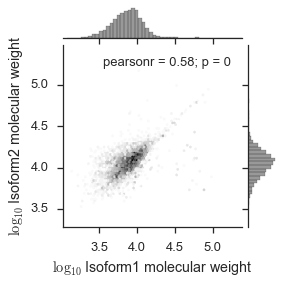

In [31]:
data = molecular_weight[molecular_weight.applymap(lambda x: isinstance(x, float))]
data = data.astype(float) 
data = np.log10(data)

g = sns.jointplot('isoform1_translation', 'isoform2_translation', data, 
                  kind='hex', joint_kws=dict(mincnt=1), color='black', size=4)
label = r'$\log_{{10}}$ Isoform{} molecular weight'
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2))
g.ax_joint.locator_params(nbins=5)
g.savefig('{}/molecular_weight_log10.pdf'.format(figure_folder))

#### Isoelectric point (pI) 

Uses the module IsoelectricPoint to calculate the [pI](https://en.wikipedia.org/wiki/Isoelectric_point) of a protein. 

In [58]:
isoelectric_point = protein_analysis.applymap(
    lambda x: x.isoelectric_point() if isinstance(x, ProtParam.ProteinAnalysis) else np.nan) 
isoelectric_point.head()

,isoform1_translation,isoform2_translation
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,4.268616
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,4.052673,4.268616
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,3.659485,4.268616
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,4.976746
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,5.161194


In [59]:
isoelectric_point.min()

isoform1_translation    2.994324
isoform2_translation    3.173767
dtype: float64

In [60]:
isoelectric_point.max()

isoform1_translation    13.519470
isoform2_translation    12.957947
dtype: float64

isoform1_translation    2.994324
isoform2_translation    3.173767
dtype: float64
isoform1_translation    13.519470
isoform2_translation    12.957947
dtype: float64


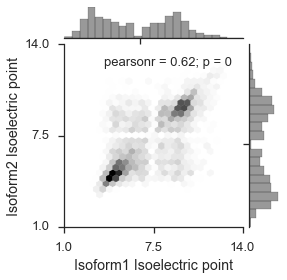

In [35]:
data = isoelectric_point
data = data[data.applymap(lambda x: isinstance(x, float))]
print data.min()
print data.max()

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data,
                  kind='hex', joint_kws=dict(mincnt=1), color='black', size=4)
label = r'Isoform{} Isoelectric point'
ticks = [1, 7.5, 14]
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2),
               xticks=ticks, yticks=ticks)
g.savefig('{}/isoelectric_point.pdf'.format(figure_folder))

#### Aromaticity

Calculates the aromaticity value of a protein according to [Lobry, 1994](http://www.ncbi.nlm.nih.gov/pubmed/8065933). It is simply the relative frequency of Phe+Trp+Tyr. 

In [62]:
aromaticity = protein_analysis.applymap(
    lambda x: x.aromaticity() if isinstance(x, ProtParam.ProteinAnalysis) else np.nan) 
aromaticity.head()

,isoform1_translation,isoform2_translation
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,0.056180
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,0.058824,0.056180
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,0.071429,0.056180
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,0.073171
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,0.115385


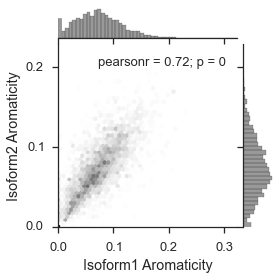

In [37]:
data = aromaticity

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data[data.applymap(lambda x: isinstance(x, float))], 
                  kind='hex', color='black', joint_kws=dict(mincnt=1), size=4)
label = r'Isoform{} Aromaticity'
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2))
g.ax_joint.locator_params(nbins=4)
g.savefig('{}/aromaticity.pdf'.format(folder))

#### Instability index

Implementation of the method of [Guruprasad et al. 1990](http://www.ncbi.nlm.nih.gov/pubmed/2075190) to test a protein for stability. Any value above 40 means the protein is unstable (has a short half life). 

In [63]:
instability_index = protein_analysis.applymap(
    lambda x: x.instability_index() if isinstance(x, ProtParam.ProteinAnalysis) else np.nan) 
instability_index.head()

,isoform1_translation,isoform2_translation
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,102.239326
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,88.447059,102.239326
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,93.594643,102.239326
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,59.580569
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,38.790769


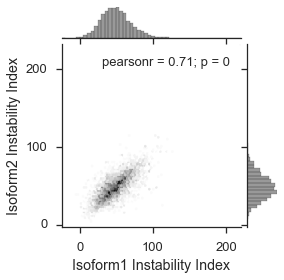

In [39]:
data = instability_index

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data[data.applymap(lambda x: isinstance(x, float))], 
                  kind='hex', color='black', joint_kws=dict(mincnt=1), size=4)
label = r'Isoform{} Instability Index'
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2))
g.ax_joint.locator_params(nbins=5)
g.savefig('{}/instability_index.pdf'.format(folder))

#### Grand average of hydropathy (GRAVY)

From [GRAVY website](http://www.bioinformatics.org/sms2/protein_gravy.html): 

> Protein GRAVY returns the GRAVY (grand average of hydropathy) value for the protein sequences you enter. The GRAVY value is calculated by adding the hydropathy value for each residue and dividing by the length of the sequence ([Kyte and Doolittle; 1982](http://www.ncbi.nlm.nih.gov/pubmed/7108955?dopt=Abstract)).

In [64]:
gravy = protein_analysis.applymap(
    lambda x: x.gravy() if isinstance(x, ProtParam.ProteinAnalysis) else np.nan) 
gravy.head()

,isoform1_translation,isoform2_translation
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,-0.664045
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,-0.710294,-0.664045
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,-0.378571,-0.664045
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,-0.070732
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,-0.003846


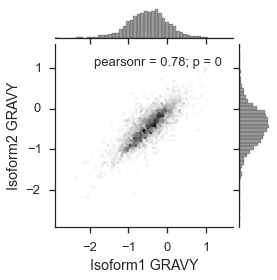

In [65]:
data = gravy

g = sns.jointplot('isoform1_translation', 'isoform2_translation', 
              data[data.applymap(lambda x: isinstance(x, float))], 
                  kind='hex', color='black', joint_kws=dict(mincnt=1), size=4)
label = r'Isoform{} GRAVY'
g.ax_joint.set(xlabel=label.format(1), ylabel=label.format(2))
# g.ax_joint.locator_params(nbins=4)
g.savefig('{}/gravy.pdf'.format(folder))

In [66]:
secondary_structure_fraction = protein_analysis.applymap(
    lambda x: pd.Series(x.secondary_structure_fraction(), index=['helix', 'turn', 'sheet']) 
    if isinstance(x, ProtParam.ProteinAnalysis) else pd.Series()) 
secondary_structure_fraction.head()

,isoform1_translation,isoform2_translation
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,"Series([], dtype: float64)",helix 0.202247 turn 0.370787 sheet 0...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,helix 0.220588 turn 0.338235 sheet 0...,helix 0.202247 turn 0.370787 sheet 0...
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,helix 0.267857 turn 0.303571 sheet 0...,helix 0.202247 turn 0.370787 sheet 0...
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,"Series([], dtype: float64)",helix 0.349593 turn 0.162602 sheet 0...
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,"Series([], dtype: float64)",helix 0.392308 turn 0.161538 sheet 0...


In [67]:
secondary_structure_tidy = pd.DataFrame(secondary_structure_fraction.unstack().to_dict()).unstack().reset_index()
secondary_structure_tidy = secondary_structure_tidy.rename(
    columns={'level_0': 'isoform', 'level_1': 'event_name', 'level_2': 'secondary_structure', 0: 'percent'})
secondary_structure_tidy.head()

,isoform,event_name,secondary_structure,percent
0,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,helix,NaN
1,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,sheet,NaN
2,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,turn,NaN
3,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,helix,0.220588
4,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,sheet,0.294118


In [68]:
secondary_structure_tidy['isoform_structure'] = secondary_structure_tidy.isoform.str.split('_').str[0] \
    + '_protein_secondary_structure_' + secondary_structure_tidy.secondary_structure
secondary_structure_tidy.head()

,isoform,event_name,secondary_structure,percent,isoform_structure
0,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,helix,NaN,isoform1_protein_secondary_structure_helix
1,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,sheet,NaN,isoform1_protein_secondary_structure_sheet
2,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,turn,NaN,isoform1_protein_secondary_structure_turn
3,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,helix,0.220588,isoform1_protein_secondary_structure_helix
4,isoform1_translation,exon:chr10:100190328-100190427:-@exon:chr10:10...,sheet,0.294118,isoform1_protein_secondary_structure_sheet


In [69]:
secondary_structure_2d = secondary_structure_tidy.pivot(columns='isoform_structure', index='event_name', values='percent')
secondary_structure_2d.head()

isoform_structure,isoform1_protein_secondary_structure_helix,isoform1_protein_secondary_structure_sheet,isoform1_protein_secondary_structure_turn,isoform2_protein_secondary_structure_helix,isoform2_protein_secondary_structure_sheet,isoform2_protein_secondary_structure_turn
event_name,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,NaN,NaN,0.202247,0.247191,0.370787
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,0.220588,0.294118,0.338235,0.202247,0.247191,0.370787
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,0.267857,0.321429,0.303571,0.202247,0.247191,0.370787
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,NaN,NaN,0.349593,0.390244,0.162602
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,NaN,NaN,0.392308,0.323077,0.161538


## Join to splicing data

In [70]:
splicing_feature_data = pd.read_csv('{}/splicing_feature_data.csv'.format(folder), index_col=0)
print splicing_feature_data.shape
splicing_feature_data.head()

(58842, 50)


,gencode_id,ensembl_id,gene_name,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,exon2_divisible_by_3,intron12_length_summed,...,isoform2_molecular_weight,isoform_domain_effects,isoform1_pfam_accession,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,492,681,148,True,829,...,9467.055499999997,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,487,681,148,True,829,...,9467.055499999997,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,70,681,148,True,829,...,9467.055499999997,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,HPS1,152,161,100,2648,460,False,3108,...,14073.84609999998,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,ENSG00000107521.14,ENSG00000107521,HPS1,138,143,152,220,1180,False,1400,...,15151.241699999982,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Join on all created dataframes

In [71]:
join_dfs = {'gravy': gravy, 'instability_index': instability_index,
            'aromaticity': aromaticity, 'isoelectric_point': isoelectric_point,
            'molecular_weight': molecular_weight, 'secondary_structure': secondary_structure_2d,
           'disordered_scores': disordered_scores_df_values, 'translation': isoform_translations}

for name, df in join_dfs.items():
    # If "translation" is in the column name, then it hasn't been renamed to its property
    if df.columns.map(lambda x: 'translation' in x).sum() > 0:
        df.columns = df.columns.map(lambda x: x.replace('translation', name))
    join_cols = df.columns.difference(splicing_feature_data.columns)
    if len(join_cols) > 0:
        splicing_feature_data = splicing_feature_data.join(df[join_cols])
    else:
        splicing_feature_data[df.columns] = df
splicing_feature_data.head()

,gencode_id,ensembl_id,gene_name,exon1_length,exon2_length,exon3_length,intron1_length,intron2_length,exon2_divisible_by_3,intron12_length_summed,...,isoform2_molecular_weight,isoform_domain_effects,isoform1_pfam_accession,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,492,681,148,True,829,...,9467.0555,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,487,681,148,True,829,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,ENSG00000107521.14,ENSG00000107521,HPS1,100,99,70,681,148,True,829,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,ENSG00000107521.14,ENSG00000107521,HPS1,152,161,100,2648,460,False,3108,...,14073.8461,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,ENSG00000107521.14,ENSG00000107521,HPS1,138,143,152,220,1180,False,1400,...,15151.2417,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
splicing_feature_data.shape

(58842, 50)

In [74]:
isoform_cols = [x for x in splicing_feature_data.columns if 'isoform' in x]
splicing_feature_data[isoform_cols].head()

,isoform1_gravy,isoform2_gravy,isoform1_iupred_score,isoform2_iupred_score,isoform1_protein_secondary_structure_helix,isoform1_protein_secondary_structure_sheet,isoform1_protein_secondary_structure_turn,isoform2_protein_secondary_structure_helix,isoform2_protein_secondary_structure_sheet,isoform2_protein_secondary_structure_turn,...,isoform2_molecular_weight,isoform_domain_effects,isoform1_pfam_accession,isoform2_pfam_accession,isoform1_pfam_name,isoform2_pfam_name,isoform1_pfam_go_name,isoform2_pfam_go_name,isoform1_pfam_go_id,isoform2_pfam_go_id
event_id,,,,,,,,,,,,,,,,,,,,,
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188908-100189399:-,NaN,-0.664045,NaN,0.638962,NaN,NaN,NaN,0.202247,0.247191,0.370787,...,9467.0555,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100188913-100189399:-,-0.710294,-0.664045,0.604310,0.638962,0.220588,0.294118,0.338235,0.202247,0.247191,0.370787,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100190328-100190427:-@exon:chr10:100189548-100189646:-@exon:chr10:100189330-100189399:-,-0.378571,-0.664045,0.552473,0.638962,0.267857,0.321429,0.303571,0.202247,0.247191,0.370787,...,9467.0555,Same status,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100193697-100193848:-@exon:chr10:100190888-100191048:-@exon:chr10:100190328-100190427:-,NaN,-0.070732,NaN,0.153085,NaN,NaN,NaN,0.349593,0.390244,0.162602,...,14073.8461,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
exon:chr10:100195392-100195529:-@exon:chr10:100195029-100195171:-@exon:chr10:100193697-100193848:-,NaN,-0.003846,NaN,0.099842,NaN,NaN,NaN,0.392308,0.323077,0.161538,...,15151.2417,No annotated reading frame --> Protein +/- domain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Save the data!

In [75]:
splicing_feature_data.to_csv('/projects/ps-yeolab/obotvinnik/singlecell_pnms/splicing_feature_data.csv')

### Out of curiosity.. how do the isoform1 and isoform2 IUPRED scores correlate?

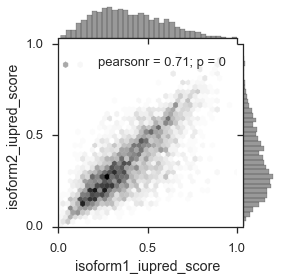

In [53]:
import seaborn as sns
sns.set(style='ticks', context='talk')
%matplotlib inline

color = 'black'

g = sns.jointplot('isoform1_iupred_score', 'isoform2_iupred_score', size=4, xlim=(0, 1), ylim=(0, 1),
                  data=disordered_scores_df_values, kind='hex', color=color, joint_kws=dict(mincnt=1))
g.ax_joint.locator_params(nbins=2)
g.fig.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/iupred_scores_jointplot_hex.pdf')

In [54]:
ind = (disordered_scores_df_values.isoform2_iupred_score > 0.8) & (disordered_scores_df_values.isoform1_iupred_score < 0.1)
disordered_scores_df_values.loc[ind]

,isoform1_iupred_score,isoform2_iupred_score
exon:chr12:53836479-53836517:+@exon:chr12:53837175-53837557:+@exon:chr12:53839799-53840320:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837175-53837557:+@exon:chr12:53839799-53840420:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837175-53837557:+@exon:chr12:53839799-53840422:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837175-53837557:+@exon:chr12:53839799-53840429:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837325-53837557:+@exon:chr12:53839799-53839878:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837325-53837557:+@exon:chr12:53839799-53840099:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837325-53837557:+@exon:chr12:53839799-53840417:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837325-53837557:+@exon:chr12:53839799-53840420:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837325-53837557:+@exon:chr12:53839799-53840429:+,0.051939,0.891813
exon:chr12:53836479-53836517:+@exon:chr12:53837351-53837557:+@exon:chr12:53839799-53839878:+,0.051939,0.891813


To make a colorbar, get the maximum values in the bins form the plot.

In [55]:
hexbins = g.ax_joint.collections[0]
vmax = np.max(hexbins.get_array())

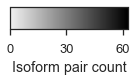

In [56]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(2, 1.25))
# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = sns.light_palette(color, as_cmap=True)
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, ticks=[0, 30, 60],
                                   norm=norm,
                                   orientation='horizontal')
cb.set_label('Isoform pair count')
fig.tight_layout()
fig.savefig('/home/obotvinnik/Dropbox/figures2/singlecell_pnm/iupred_scores_jointplot_hex_colorbar.pdf')